In [56]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from matplotlib.ticker import MaxNLocator,AutoMinorLocator,MultipleLocator

In [57]:
import os
import pickle

raw_files = [(x[0], x[2]) for x in os.walk('../exh-b-o-comparison')][0]
raw_files

('../exh-b-o-comparison',
 ['Exh+E.txt',
  'Exh+E+B.txt',
  'ICTS-m+ID+E.txt',
  'ICTS-m+ID.txt',
  'ICTS-m+ID+S.txt',
  'Exh+E+B+O.txt',
  'ICTS-m+ID+S+C.txt',
  'Exh+E+B+O+ID.txt',
  'ICTS-m.txt',
  'Exh+S+C+B+O.txt'])

In [58]:
from collections import defaultdict
import pandas as pd
import re
result_maps = dict()
map_types = set()
for file in raw_files[1]:
    name = os.path.splitext(file)[0]
    if name not in ['ICTS-m','ICTS-m+ID+S']:
        df = pd.read_csv("../exh-b-o-comparison/" + file)
        result_maps[name] = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
        results = result_maps[name]
        for d in df.iterrows():
            data = d[1]
            setting = data[0]
            m = re.match('([A-Za-z0-9]*)-20x20-A(\d+)_T(\d+)',setting)
            map_type = m.group(1)
            map_types.add(map_type)
            agents = int(m.group(2))
            teams = int(m.group(3))
            results[map_type][teams][agents] = (data[2],data[1])
        print(results)
    

defaultdict(<function <lambda> at 0x7fd19712aee0>, {'25': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fd19718bee0>, {1: defaultdict(<class 'dict'>, {1: (0.0277781173790572, 1.0), 2: (0.1422902309786877, 1.0), 3: (0.4946847929205978, 1.0), 4: (4.464744824961818, 1.0), 5: (35.8325178909392, 1.0), 6: (120.03028177933942, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.0256675133007229, 1.0), 2: (0.0692950503400061, 1.0), 3: (0.0985927241801982, 1.0), 4: (0.442538561062247, 1.0), 5: (1.7807991332592792, 1.0), 6: (10.600994839080377, 0.96), 7: (24.37970431487949, 1.0), 8: (93.2594782788804, 0.64), 9: (120.03656420807964, 0.0)})}), '75': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fd19718b310>, {1: defaultdict(<class 'dict'>, {1: (0.009369383919402, 1.0), 2: (0.9085959181989892, 1.0), 3: (43.09035470088042, 0.72), 4: (104.34168322050216, 0.18), 5: (120.03300411115896, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.0063848912410321, 1.0), 2: (0.9797743757610442, 1.0), 3: (2

1
25


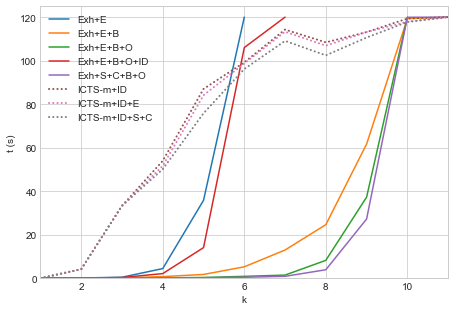

75


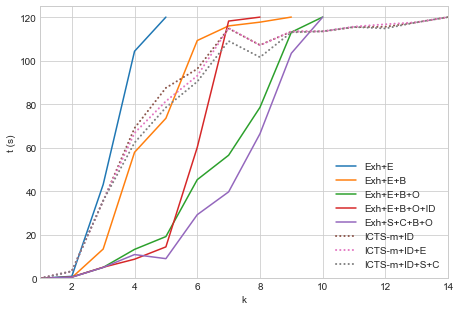

3
25


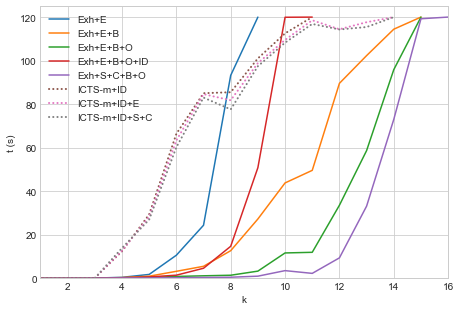

75


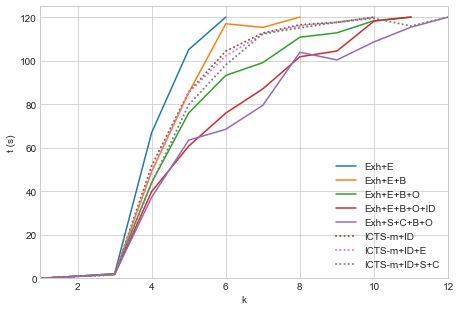

1
25


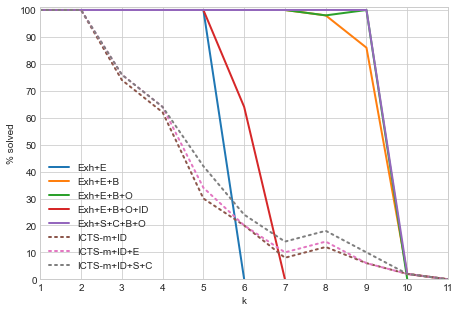

75


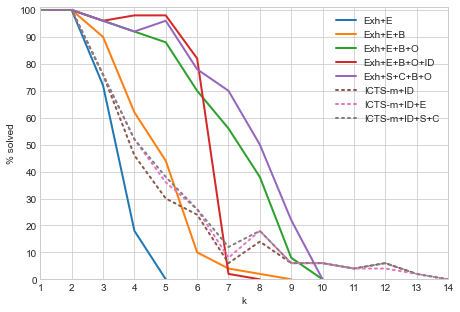

3
25


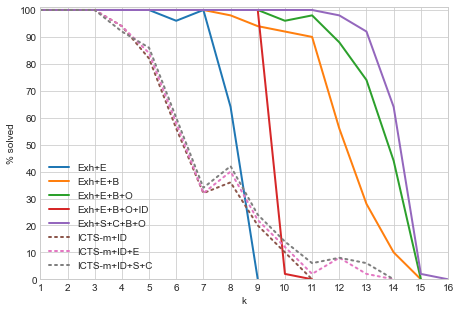

75


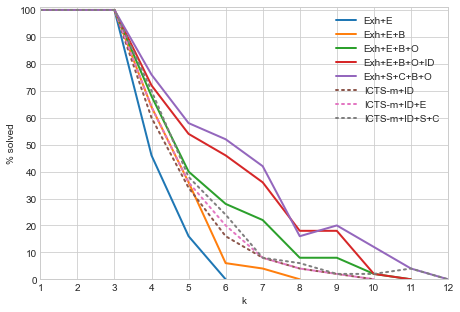

In [79]:
for team_size in [1,3]:
    print(team_size)
    for map_type in map_types:
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots()
        plt.subplots_adjust(hspace=0.3)
        plt.tight_layout(pad=0)
        plt.margins(0, 0)
        plt.grid(True)
        max_len = 0
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
            max_len = max(max_len,len(data.keys()))
        plt.axis([1, max_len, 0, 125])
        print(map_type)
        for name in sorted(result_maps):
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: x[0],data.values()))
#             print(times)
            if name.find('ICTS-m'):
                plt.plot(keys,values, label = name)
            else:
                plt.plot(keys,values,label=name,linestyle = (0,(0.1,2)),dash_capstyle = 'round',linewidth = 2,)
        plt.xlabel('k')
        plt.ylabel('t (s)')
        plt.legend()
        plt.savefig("{}-{}".format(map_type.lower(),team_size))
        plt.show()
for team_size in [1,3]:
    print(team_size)
    for map_type in map_types:
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots()
        plt.subplots_adjust(hspace=0.3)
        plt.tight_layout(pad=0)
        plt.margins(0, 0)
        plt.grid(True)
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        max_len = 0
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
            max_len = max(max_len,len(data.keys()))
        plt.axis([1, max_len, 0, 101])
        print(map_type)
        for name in sorted(result_maps):
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: 100 * x[1],data.values()))
#             print(times)
            if name.find('ICTS-m'):
                ax.plot(keys,values, label = name,linewidth = 2)
            else:
                ax.plot(keys,values,label=name,linestyle = (0,(1,2)),dash_capstyle = 'round',linewidth = 2,)
        plt.xlabel('k')
        plt.ylabel('% solved')
        plt.legend()
        plt.savefig("../plots/relative-comparison/{}-{}-p".format(map_type.lower(),team_size),bbox_inches="tight", pad_inches=0, format='eps')
        plt.savefig("../plots/relative-comparison/{}-{}-p".format(map_type.lower(),team_size),bbox_inches="tight", pad_inches=0, format='png')
        plt.show()